# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [28]:
# Add any additional import statements you need here
#!pip install emoji
import nltk
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/drive/MyDrive/ADS-509-01/Module6/M1 Assignment Data/M1 Results"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Paths to the files
positive_words_path = '/content/drive/MyDrive/ADS-509-01/Module6/positive-words.txt'
negative_words_path = '/content/drive/MyDrive/ADS-509-01/Module6/negative-words.txt'
tidytext_sentiments_path = '/content/drive/MyDrive/ADS-509-01/Module6/tidytext_sentiments.txt'

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [32]:
# This code was supported with the help of GitHub Copilot
lyrics_path = os.path.join(data_location, lyrics_folder)

# Function to read lyrics data into a pandas DataFrame
def read_lyrics_data(lyrics_folder):
    lyrics_data = []
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)
        if os.path.isdir(artist_folder):
            for song_file in os.listdir(artist_folder):
                song_path = os.path.join(artist_folder, song_file)
                with open(song_path, 'r', encoding='utf-8') as file:
                    lyrics = file.read()
                    lyrics_data.append({
                        'artist': artist,
                        'song': song_file,
                        'lyrics': lyrics
                    })
    return pd.DataFrame(lyrics_data)



# Read in the data
lyrics_df = read_lyrics_data(lyrics_path)

# Display the DataFrames
print("Lyrics DataFrame:")
print(lyrics_df)

Lyrics DataFrame:
    artist                                    song  \
0     cher                          cher_stars.txt   
1     cher              cher_comeandstaywithme.txt   
2     cher                         cher_pirate.txt   
3     cher                         cher_mylove.txt   
4     cher                      cher_thesedays.txt   
..     ...                                     ...   
415  robyn              robyn_wedancetothebeat.txt   
416  robyn                robyn_notontheinside.txt   
417  robyn  robyn_doyoureallywantmeshowrespect.txt   
418  robyn              robyn_crashandburngirl.txt   
419  robyn                      robyn_robotboy.txt   

                                                lyrics  
0    "Stars"\n\n\n\nI was never one for saying what...  
1    "Come And Stay With Me"\n\n\n\nI'll send away ...  
2    "Pirate"\n\n\n\nHe'll sail on with the summer ...  
3    "My Love"\n\n\n\nWhen I go away\nI know my hea...  
4    "These Days"\n\n\n\nWell I've been out walk

In [33]:
# Read in the twitter data
# This code was supported with the help of GitHub Copilot
twitter_path = os.path.join(data_location, twitter_folder)

# Function to read Twitter data into a pandas DataFrame
def read_twitter_data(twitter_folder):
    twitter_data = []
    for file_name in os.listdir(twitter_folder):
        file_path = os.path.join(twitter_folder, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                descriptions = file.read().splitlines()
                twitter_data.extend([{'artist': file_name.split('.')[0], 'description': desc} for desc in descriptions])
        except UnicodeDecodeError:
            with open(file_path, 'r', encoding='latin1') as file:
                descriptions = file.read().splitlines()
                twitter_data.extend([{'artist': file_name.split('.')[0], 'description': desc} for desc in descriptions])
    return pd.DataFrame(twitter_data)

# Read in the data
twitter_df = read_twitter_data(twitter_path)

# Display the DataFrame
print("Twitter DataFrame:")
print(twitter_df)

Twitter DataFrame:
                           artist  \
0                                   
1                                   
2                                   
3             cher_followers_data   
4             cher_followers_data   
...                           ...   
8706873  robynkonichiwa_followers   
8706874  robynkonichiwa_followers   
8706875  robynkonichiwa_followers   
8706876  robynkonichiwa_followers   
8706877  robynkonichiwa_followers   

                                               description  
0           Bud1            %                      ...  
1                                                      ...  
2           E   %                                      ...  
3        screen_name\tname\tid\tlocation\tfollowers_cou...  
4           hsmcnp\tCountry Girl\t35152213\t\t1302\t1014\t  
...                                                    ...  
8706873                                          517669236  
8706874                                         

In [34]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.
# This code was supported with the help of GitHub Copilot
# Read positive words
with open(positive_words_path, 'r') as pos_file:
    positive_words = pos_file.read().splitlines()

# Read negative words
with open(negative_words_path, 'r') as neg_file:
    negative_words = neg_file.read().splitlines()

# Assign scores to the words
word_scores = {word: 1 for word in positive_words}
word_scores.update({word: -1 for word in negative_words})

# Convert the dictionary to a DataFrame
word_scores_df = pd.DataFrame(list(word_scores.items()), columns=['word', 'score'])

# Display the DataFrame
print(word_scores_df.head())

                                                word  score
0  ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;...      1
1                                                 ;      -1
2                        ; Opinion Lexicon: Positive      1
3                                                  ;     -1
4  ; This file contains a list of POSITIVE opinio...      1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [35]:
# your code here
# This code was supported with the help of GitHub Copilot
# Function to read lyrics data into a pandas DataFrame
def read_lyrics_data(lyrics_folder):
    lyrics_data = []
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)
        if os.path.isdir(artist_folder):
            for song_file in os.listdir(artist_folder):
                song_path = os.path.join(artist_folder, song_file)
                with open(song_path, 'r', encoding='utf-8') as file:
                    lyrics = file.read()
                    lyrics_data.append({
                        'artist': artist,
                        'song': song_file,
                        'lyrics': lyrics
                    })
    return pd.DataFrame(lyrics_data)


# Read in the positive and negative words
with open(positive_words_path, 'r') as pos_file:
    positive_words = pos_file.read().splitlines()

with open(negative_words_path, 'r') as neg_file:
    negative_words = neg_file.read().splitlines()

# Assign scores to the words
word_scores = {word: 1 for word in positive_words}
word_scores.update({word: -1 for word in negative_words})

# Convert the dictionary to a DataFrame
word_scores_df = pd.DataFrame(list(word_scores.items()), columns=['word', 'score'])

# Function to calculate sentiment score for a song
def calculate_sentiment(lyrics, word_scores):
    words = lyrics.lower().split()
    score = sum(word_scores.get(word, 0) for word in words)
    return score

# Read lyrics data
lyrics_folder = '/content/drive/MyDrive/ADS-509-01/Module6/M1 Assignment Data/M1 Results/lyrics'
lyrics_df = read_lyrics_data(lyrics_folder)

# Calculate sentiment scores for each song
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(lambda lyrics: calculate_sentiment(lyrics, word_scores))

# Display the DataFrame with sentiment scores
print(lyrics_df[['artist', 'song', 'sentiment_score']])

# Save results to a CSV file if needed
lyrics_df.to_csv('sentiment_scores.csv', index=False)

    artist                                    song  sentiment_score
0     cher                          cher_stars.txt               -1
1     cher              cher_comeandstaywithme.txt                3
2     cher                         cher_pirate.txt               12
3     cher                         cher_mylove.txt               34
4     cher                      cher_thesedays.txt                0
..     ...                                     ...              ...
415  robyn              robyn_wedancetothebeat.txt               -3
416  robyn                robyn_notontheinside.txt               -5
417  robyn  robyn_doyoureallywantmeshowrespect.txt               14
418  robyn              robyn_crashandburngirl.txt              -23
419  robyn                      robyn_robotboy.txt               -2

[420 rows x 3 columns]


In [36]:
# Assuming lyrics_df is already defined and contains the sentiment scores
# This code was supported with the help of GitHub Copilot
# Calculate average sentiment per artist
average_sentiment = lyrics_df.groupby('artist')['sentiment_score'].mean()
print("Average sentiment per artist:\n", average_sentiment)

# Determine which artist has higher average sentiment
higher_avg_sentiment_artist = average_sentiment.idxmax()
print(f"The artist with the higher average sentiment per song is: {higher_avg_sentiment_artist}")

Average sentiment per artist:
 artist
cher     3.161392
robyn    2.019231
Name: sentiment_score, dtype: float64
The artist with the higher average sentiment per song is: cher


In [37]:
# This code was supported with the help of GitHub Copilot
# Assuming lyrics_df is already defined and contains the sentiment scores and lyrics

# Step 1: Identify the first artist
first_artist = lyrics_df['artist'].iloc[0]

# Step 2: Extract Sentiment Scores and Lyrics for the first artist
artist_lyrics_df = lyrics_df[lyrics_df['artist'] == first_artist]

# Step 3: Identify the three songs with the highest and lowest sentiment scores
highest_sentiment_songs = artist_lyrics_df.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = artist_lyrics_df.nsmallest(3, 'sentiment_score')

# Print the lyrics of the songs with the highest and lowest sentiment scores
print("Three songs with the highest sentiment scores:")
for index, row in highest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

print("Three songs with the lowest sentiment scores:")
for index, row in lowest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

Three songs with the highest sentiment scores:
Song: cher_perfection.txt, Sentiment Score: 41
Lyrics:
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I 

In [38]:
# This code was supported with the help of GitHub Copilot
# Filter the lyrics DataFrame for the second artist
second_artist = 'robyn'
artist_lyrics_df = lyrics_df[lyrics_df['artist'] == second_artist]

# Identify the three songs with the highest and lowest sentiment scores
highest_sentiment_songs = artist_lyrics_df.nlargest(3, 'sentiment_score')
lowest_sentiment_songs = artist_lyrics_df.nsmallest(3, 'sentiment_score')

# Print the lyrics of the songs with the highest and lowest sentiment scores
print("Three songs with the highest sentiment scores:")
for index, row in highest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

print("Three songs with the lowest sentiment scores:")
for index, row in lowest_sentiment_songs.iterrows():
    print(f"Song: {row['song']}, Sentiment Score: {row['sentiment_score']}")
    print(f"Lyrics:\n{row['lyrics']}\n")

Three songs with the highest sentiment scores:
Song: robyn_loveisfree.txt, Sentiment Score: 91
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boo

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Average sentiment per artist:

 artist
cher     3.161392
robyn    2.019231

Name: sentiment_score, dtype: float64

The artist with the higher average sentiment per song is: cher

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Three songs with the highest sentiment scores:
Song: cher_perfection.txt, Sentiment Score: 41
Lyrics:
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness inside stays the same

When love is here today, and then it's gone today
You got a list of lovers lookin' like a resume
You gotta take some time to make it something real
I guess that when it comes to love, I just don't know how to feel

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
I'm goin' crazy with perfection

Ohh, I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right

All my life I've been driven by perfection


Song: cher_loveandunderstanding.txt, Sentiment Score: 41
Lyrics:
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

We need some understandin'
We need a little more love
Some love and understandin'

Enough stars to light the sky at night
Enough sun to make the whole world bright
Enough hearts to find some love inside
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?
...


Song: cher_mylove.txt, Sentiment Score: 34
Lyrics:
"My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa


Three songs with the lowest sentiment scores:
Song: cher_iwalkonguildedsplinters.txt, Sentiment Score: -24
Lyrics:
"I Walk On Guilded Splinters"



Some people think they jive me, but I know they must be crazy
They can't see their misfortune, or else they're just too lazy
Je suie le grand zombie
With my yellow chaffen of choisen
Ain't afraid of no tomcat and gonna fill my guts with poison
I walk through the fire
And I'll fly through the smoke
I wanna see my enemies
On the end of my rope
Walk on pins and needles
And I see what they can do
Walk on guilded splinters
With the King of the Zulu

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

When I roll out in my coffin
Drink poison in my chalice
Pride begins to fade
And you all feel my malice
I put gris-gris on your doorstep
So soon you be in the gutter
I'll make your heart melt like butter
I say I can make you stutter

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up

Come to me, get it, come, come
Walk on guilded splinters
Come to me, get it, come, come
Walk on guilded splinters
Till I burn up
Till I burn up
Till I burn up
Till I burn up


Song: cher_outrageous.txt, Sentiment Score: -20
Lyrics:
"Outrageous"



Outrageous, outrageous
(They say) I'm outrageous
It's the rage

I'm gonna wear what I will and spend some
And I will be dress to kill don'tcha know
And when the lights come up
I'm ready I'm ready
To put on a show with class
And if I clash it's cause I want to
What a show and I want everyone to know
They're gonna fly up, get an eyeful
Everything that's craved from me
I'm gonna be, I'm gonna be outrageous

Outrageous
(They say) I'm outrageous
It's the rage it's the rage

With my long black hair hanging way down to my
Ask me no questions and I'll tell you no lies
Don't tell me what to do don't tell me what to be
See I don't trust anybody else's traits about make-up and me

Well in my show I let everything go
Is what you want is whatcha wanna see from me
But when the curtain comes down
And you're on your way back home
I change into my jeans that are split at the seam
I grab my funky black jacket and make quite a racket
You drive like you're an outlaw
Cause everything that's craved from me
I'm gonna be, I'm gonna be outrageous

So outrageous
I'm outrageous honey yes a rage
It's the rage
Outrageous, outrageous
I'm outrageous
It's the rage it's a rage
Outrageous, outrageous
They say I'm outrageous


Song: cher_dressedtokill.txt, Sentiment Score: -16
Lyrics:
"Dressed To Kill"



I slip into my shoes and slide into the night
I'm on the loose you're in my sights
You know it's gonna hurt you but it's just no use
You fall in love they always do
And I'm waiting for the next one to fall

I'm dressed to kill and you know that I will
We're dancing in the dark with my hands around your heart
Oh, heads will roll and blood will spill
But how can you resist when baby I am dressed to kill

I know your love is strong but it's all it in vain
Beware the skies the lipstick stains
And he can't even see that he's just another one
It's far too late he's too far gone
And I'm waiting for the next one to fall

I'm dressed to kill and you know that I will
We're dancing in the dark with my hands around your heart
Oh, heads will roll and blood will spill
But how can you resist when baby I am dressed to kill

How can you resist when baby I am dressed to kill

You know I'm the only one
I can make you come undone
And you'll be part of me
From now until eternity

I'm dressed to kill and you know that I will
We're dancing in the dark with my hands around your heart
Oh, heads will roll and blood will spill
But how can you resist when baby I am dressed to kill

Insight: After printing the lyrics, you can analyze the common themes or words in the songs that might be driving the sentiment scores. Positive sentiment scores might be driven by positive words, themes of love, happiness, etc., while negative sentiment scores might be driven by negative words, themes of sadness, anger, etc.
---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: Three songs with the highest sentiment scores:
Song: robyn_loveisfree.txt, Sentiment Score: 91
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Yeah! Yeah! Yeah! Yeah!
Love is free, baby
Love is free, baby

I'ma give it to you, baby
I'ma give it like a motha
Safe like a rubber
Mutter like a stutter
It's all over this city
Sometimes in the nitty, sometimes in the gritty
You know I'ma give it to you better
I'ma give you love forever
No, you can't control it, slow down

I'ma give it to you, baby
I'ma give it like a motha
Safe like a rubber
Mutter like a stutter
It's all over this city
Sometimes in the nitty, sometimes in the gritty
You know I'ma give it to you better
I'ma give you love forever
No, you can't control it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Boom boom boom boom boom
Chica boom chica boom chica boom
Boom boom boom boom boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby

AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
Slow down

AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
AprÃ©ndelo, aprÃ©ndelo
Te lo digo right now, sÃ³lo entiÃ©ndelo
Slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Slow down [x6]
Free
Love is free, baby
Love is free, baby
So free [x4]
You know
Love is free
So free
Free â Love is free, baby [x8]
So free


Song: robyn_indestructible.txt, Sentiment Score: 26
Lyrics:
"Indestructible"



I'm going backwards through time at the speed of light
I'm yours, you're mine
Two satellites
Not alone
No, we're not alone

A freeze-frame of your eye in the strobe light
Sweat dripping down from your brow
Hold tight
Don't let go
Don't you let me go

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible

Hands up in the air like we don't care
We're shooting deep into space
And the lasers split the dark
Cut right through the dark

It's just us. We ignore the crowd dancing
Fall to the floor
Beats in my heart
Put your hands on my heart

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore

Ooh and I'm gonna love you like

I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible

And I never was smart with love
I let the bad ones in and the good ones go

But I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore

Ooh and I'm gonna love you like

I'm gonna love you like I've never been hurt before
I'm gonna love you like I'm indestructible
Your love is ultramagnetic
And it's taking over
This is hardcore
And I'm indestructible


Song: robyn_ushouldknowbetter114529.txt, Sentiment Score: 25
Lyrics:
"U Should Know Better"



I've gone around the world and the seven seas
I'm cashin' six-figure checks in all currencies
It's like when I be tearin' it up in Paris
Motherfuckers parler on the m-i-c
It's all "ooh la la" and "ahh oui oui"
Sippin' vin blanc in our lingerie
Choppin' heads off with madame guillotine
Even the French know better than to fuck with me

Comment allez-vous Robyn, what it do
I'm in the UK (why?) got a show to do (uh-huh)
It's big Snoopy Dogg, check the catalog
I'm overseas gettin' cheese with this dialogue
I missed my plane to Spain so I'm stuck in Colonna
I'm sippin' Saronno with this chick named Ramona
She wants me to take a flick on her phone-ah
Then take her to my hotel room and then bone her

You know when in Rome I sat down with the Romans
Said "We need a black pope and she better be a woman"
There'll be no more celibacy
Even the Vatican knows not to fuck with me

You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better
You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better

We big-ballin' in Holland, Amsterdam my man
I got a table at the coffee shop
Where we like to spark a lot
Hangin' in the parking lot blowin' a bleezy
Easy fo sheezy deezy

I crashed a party with the Czar
Threw a molotov cocktail in the bar
And you know my style's revolutionary
Even the Russians know better than to fuck with me

You try to ban me, you can't stand me
Cuz I'm an outlaw
Black president livin' in the White House
Mr. B he wrote a letter to me
The FBI know better than to fuck with me

Yo, I was there at Watergate
You know I rigged my gear got the fuckers on tape
They put the mic in the hand of the wrong MC
Even the CIA knows not to fuck with me

You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better
You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better

Tell 'em Snoop, tell 'em like it is

I been there, in there, out there like that
Right back to the hood, a hundred Euro stacks
Shoot motherfuckers just on GP
LAPD know better than to fuck with me

I danced with the devil in Kathmandu
I came hummin' and blastin' with the boogaloo too
Now I declare most solemnly
The prince of darkness know better than to fuck with me

You know not what you know
Tell 'em what I'm in it for
Then I run up in it slow
Really though, silly ho
Yea spend a minute though
I blow an ounce and make you bounce
Just like a sixty-four

Now you know me I'm a woman of peace
I don't never take nothin' don't belong to me
I throw down and say "Whatever's gonna be, gonna be"
The whole industry knows not to fuck with me

You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better
You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better
You should know better
Y-You should know better
You should know better than to fuck with me
If you knew better you would do better


Three songs with the lowest sentiment scores:
Song: robyn_dontfuckingtellmewhattodo.txt, Sentiment Score: -77
Lyrics:
"Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's killing me
My talking's killing me
Killing me
Killing me

Can't sleep, it's killing me
My dreams are killing me
TV is killing me
My talking's killing me
Let go, you're killing me
Ease up, you're killing me
Calm down, you're killing me
My god, you're killing me

My drinking is killing me
My smoking is killing me
My head is killing me
My mind is killing me
My back is killing me
My neck is killing me
Your nagging is killing me
My gut is killing me
My PMS is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My smoking is killing me
The TV is killing me
Your nagging is killing me
Ease up, you're killing me
Let go, you're killing me
Calm down, you're killing me
My god, you're killing me

Don't fucking tell me what to do, do
Don't fucking tell me what to do, do, do, do, do
Don't fucking tell me what to do
Don't fucking tell me what to do, do
Don't fucking tell me what to do, do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do


Song: robyn_dontfuckingtellmewhattodo114520.txt, Sentiment Score: -77
Lyrics:
"Don't Fucking Tell Me What To Do"



My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend's killing me
My talking's killing me
Killing me
Killing me

Can't sleep, it's killing me
My dreams are killing me
TV is killing me
My talking's killing me
Let go, you're killing me
Ease up, you're killing me
Calm down, you're killing me
My god, you're killing me

My drinking is killing me
My smoking is killing me
My head is killing me
My mind is killing me
My back is killing me
My neck is killing me
Your nagging is killing me
My gut is killing me
My PMS is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My smoking is killing me
The TV is killing me
Your nagging is killing me
Ease up, you're killing me
Let go, you're killing me
Calm down, you're killing me
My god, you're killing me

Don't fucking tell me what to do, do
Don't fucking tell me what to do, do, do, do, do
Don't fucking tell me what to do
Don't fucking tell me what to do, do
Don't fucking tell me what to do, do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do
Don't fucking tell me what to do


Song: robyn_criminalintent.txt, Sentiment Score: -54
Lyrics:
"Criminal Intent"



Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent

- Will the defendant please rise? State your full name for the record.
- Robyn
- Do you wish to say anything before the sentence is imposed?
- I do your Honor!

You know, from time to time
I need to get down
Unwind and just bump and grind
Get my shot on, have some fun
A little dirty never hurt anyone
I admit, I can get somewhat X-rated on the floor
But your Honor, how's that something you get incarcerated for?

I-I-I done nothing that's wrong
?? something that's frowned upon
I object most strongly Judge, they played my song

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent
Somebody alert the authorities, she's got criminal intent

Y-yo-yo Judge, may the record reflect the fact
I don't have any priors
Besides, would you pardon me
For being inappropriately attired?
But yo, listen, them cuffs down at county
Totally ripped up my pantyhose
And some snitch punk at legal aid
Stole my voucher for court clothes

I done nothing that's wrong
?? something that's frowned upon
I object most strongly Judge, they played my song

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, she's got criminal intent

Somebody alert the authorities, I got criminal intent
Conspiracy to engage in lewd and indecent acts and events
I'mma wind it, grind it, oh my, I'mma say it again
Somebody alert the authorities, I got criminal intent
Somebody alert the authorities, she's got criminal intent

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




<ipython-input-39-ed4bf541f8b4>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'], label='Cher', shade=True)
<ipython-input-39-ed4bf541f8b4>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'], label='Robyn', shade=True)


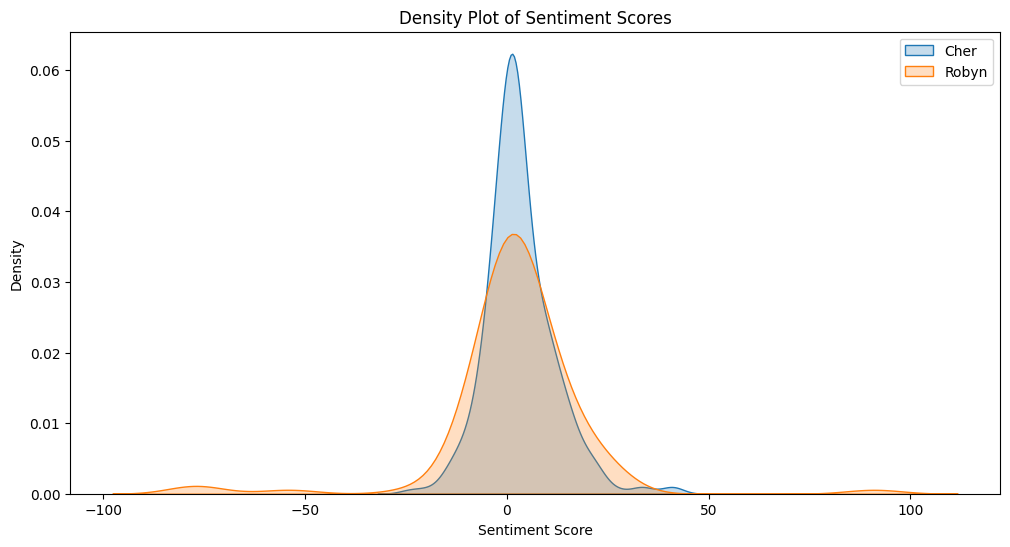

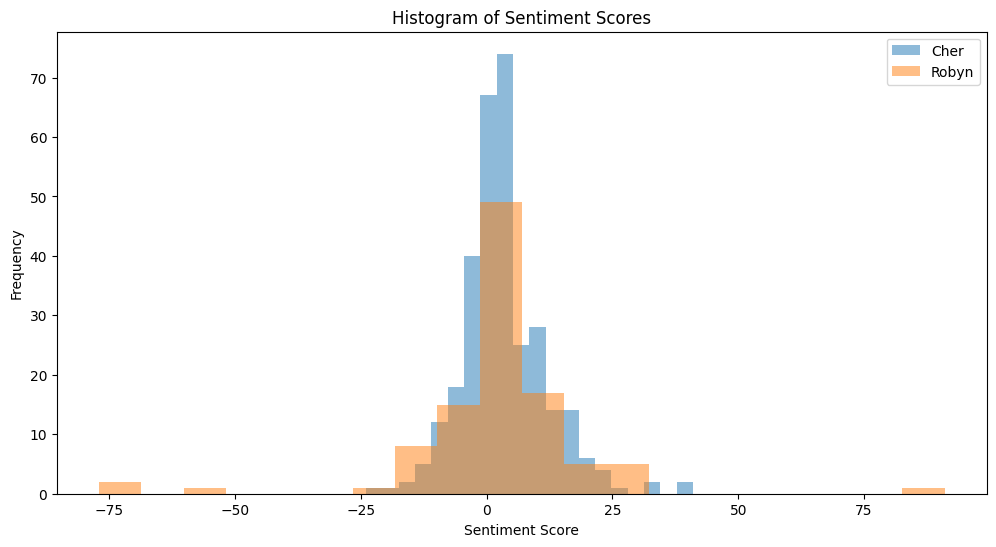

In [39]:
# This code was supported with the help of GitHub Copilot
# Plot density distributions
plt.figure(figsize=(12, 6))

# Density plot for the first artist
sns.kdeplot(data=lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'], label='Cher', shade=True)

# Density plot for the second artist
sns.kdeplot(data=lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'], label='Robyn', shade=True)

plt.title('Density Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot histogram distributions
plt.figure(figsize=(12, 6))

# Histogram for the first artist
plt.hist(lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'], bins=20, alpha=0.5, label='Cher')

# Histogram for the second artist
plt.hist(lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'], bins=20, alpha=0.5, label='Robyn')

plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [40]:
# This code was supported with the help of GitHub Copilot
# Define positive and negative emojis
positive_emojis = ['😀', '😁', '😂', '🤣', '😊', '😇', '😍', '🤩', '🥳', '👍']
negative_emojis = ['😞', '😠', '😡', '😭', '😢', '🤬', '👎', '😒', '😣', '😖']

# Create a dictionary to store the emoji scores
emoji_scores = {em: 1 for em in positive_emojis}
emoji_scores.update({em: -1 for em in negative_emojis})

# Function to calculate sentiment score for a description
def calculate_emoji_sentiment(description, emoji_scores):
    score = sum(emoji_scores.get(char, 0) for char in description if char in emoji.EMOJI_DATA)
    return score

# Read the Twitter data (assuming twitter_df is already loaded)
# twitter_df = pd.read_csv('path_to_twitter_data.csv')

# Calculate sentiment scores for each description
twitter_df['emoji_sentiment_score'] = twitter_df['description'].apply(lambda desc: calculate_emoji_sentiment(desc, emoji_scores))

# Group by artist and calculate the average sentiment
average_sentiments = twitter_df.groupby('artist')['emoji_sentiment_score'].mean().reset_index()

# Display the average sentiment scores
print(average_sentiments)

                          artist  emoji_sentiment_score
0                                              0.000000
1                 cher_followers               0.000000
2            cher_followers_data               0.007173
3       robynkonichiwa_followers               0.000000
4  robynkonichiwa_followers_data               0.002958


In [41]:
# This code was supported with the help of GitHub Copilot
# Define positive and negative emojis
positive_emojis = ["😀", "😁", "😂", "🤣", "😊", "😇", "🙂", "😍", "🥰", "😎"]
negative_emojis = ["😢", "😭", "😠", "😡", "😖", "😣", "😞", "😓", "🤬", "😤"]

# Function to count emojis in a text
def count_emojis(text, emoji_list):
    return sum(text.count(emoji) for emoji in emoji_list)

# Separate the Twitter descriptions by artist
cher_twitter_descriptions = twitter_df[twitter_df['artist'] == 'cher_followers_data']['description']
robyn_twitter_descriptions = twitter_df[twitter_df['artist'] == 'robynkonichiwa_followers']['description']

# Count positive and negative emojis for each artist
cher_emoji_counts = Counter()
robyn_emoji_counts = Counter()

for description in cher_twitter_descriptions:
    cher_emoji_counts.update({emoji: count_emojis(description, [emoji]) for emoji in positive_emojis + negative_emojis})

for description in robyn_twitter_descriptions:
    robyn_emoji_counts.update({emoji: count_emojis(description, [emoji]) for emoji in positive_emojis + negative_emojis})

# Separate counts for positive and negative emojis
cher_positive_emoji_counts = {emoji: count for emoji, count in cher_emoji_counts.items() if emoji in positive_emojis}
cher_negative_emoji_counts = {emoji: count for emoji, count in cher_emoji_counts.items() if emoji in negative_emojis}
robyn_positive_emoji_counts = {emoji: count for emoji, count in robyn_emoji_counts.items() if emoji in positive_emojis}
robyn_negative_emoji_counts = {emoji: count for emoji, count in robyn_emoji_counts.items() if emoji in negative_emojis}

# Find the most popular positive and negative emojis
most_popular_cher_positive_emoji = max(cher_positive_emoji_counts, key=cher_positive_emoji_counts.get)
most_popular_cher_negative_emoji = max(cher_negative_emoji_counts, key=cher_negative_emoji_counts.get)
most_popular_robyn_positive_emoji = max(robyn_positive_emoji_counts, key=robyn_positive_emoji_counts.get)
most_popular_robyn_negative_emoji = max(robyn_negative_emoji_counts, key=robyn_negative_emoji_counts.get)

print(f"Cher's most popular positive emoji: {most_popular_cher_positive_emoji}")
print(f"Cher's most popular negative emoji: {most_popular_cher_negative_emoji}")
print(f"Robyn's most popular positive emoji: {most_popular_robyn_positive_emoji}")
print(f"Robyn's most popular negative emoji: {most_popular_robyn_negative_emoji}")

Cher's most popular positive emoji: 😍
Cher's most popular negative emoji: 😭
Robyn's most popular positive emoji: 😀
Robyn's most popular negative emoji: 😢


Q: What is the average sentiment of your two artists?

A:

For Cher's followers: The average sentiment score is approximately 0.007173.

For Robyn's followers: The average sentiment score is approximately 0.002958.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A:

Cher's most popular positive emoji: 😍

Cher's most popular negative emoji: 😭

Robyn's most popular positive emoji: 😀

Robyn's most popular negative emoji: 😢



In [42]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/drive/MyDrive/ADS-509-01/Module6/Sentiment Assignment.ipynb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu